---
title: "Forecasting with Single Models and Ensemble on Univariate Time Series Data"
format:
  html:
    code-fold: false
    code-summary: "Show code"
---

Supervised ML workflow for building time series forecasting models on univariate time series data.

Uses the `seaice` dataset from **seaborn**, and applies several time series models to forecast sea ice extent (Naive Mean, ARIMA, Exponential Smoothing, LightGBM with lagged features, Theta).
    
Also trains a stage-2 **ensemble model** (linear regression) on top of the base model predictions.

This dataset contains no missing values, so no imputation is used.

Key points:

- Splits the data into train, validation, and test sets 
- Scales all series using `darts`' Scaler; note: AutoARIMA and ExponentialSmoothing typically work with unscaled data
- Trains each model on the training set and evaluates on the validation and test sets  
- Builds an ensemble model using predictions from several base models on the validation set, and evaluates it on the test set  
- Plots the full series for visual inspection of model performance  

In this setup, AutoARIMA performed best on the test set, and the ensemble model did not outperform the best base model.

::: {.callout-note collapse="true" title="Note: Using `display` for HTML tables"}
`print(summarize(df))` and `print(df.head())` return tables printed in plain text. To get nicer-formatted HTML tables, use the following instead of `print()`:

```{.python}
from IPython.display import display
display(df.head())

# Display summary
display(summarize(df))
```
:::

----- SCRIPT OUTPUT -----

----- First Few Rows of Data -----

        Date  Extent
0 1980-01-01  14.200
1 1980-01-03  14.302
2 1980-01-05  14.414
3 1980-01-07  14.518
4 1980-01-09  14.594

----- Data Summary -----

                 dtype  count  unique  missing  zero   mean   std   min    50%    max  skew
Extent         float64  13175    7649        0     0  11.29  3.28  3.34  11.98  16.41 -0.44
Date    datetime64[ns]  13175   13175        0     0                                       

----- darts TimeSeries Summary -----

frequency:  MS
Train range: 1980-01-01 to 2007-12-01 (336 steps)
Val   range: 2008-01-01 to 2015-12-01 (96 steps)
Test  range: 2016-01-01 to 2019-12-01 (48 steps)

----- Training Models -----

Training NaiveMean...
Training AutoARIMA...


Training ExponentialSmoothing...
Training LightGBMModel...


Training Theta...

Training Ensemble Model...

----- EVALUATION -----

               Model      MAE     RMSE  Train Time (s)
           AutoARIMA 0.441777 0.522898        2.799177
            Ensemble 0.516080 0.596180        0.001000
       LightGBMModel 0.508478 0.669340        1.348999
ExponentialSmoothing 0.610640 0.694622        0.086801
               Theta 0.639187 0.739195        0.004991
           NaiveMean 3.021945 3.652156        0.000000


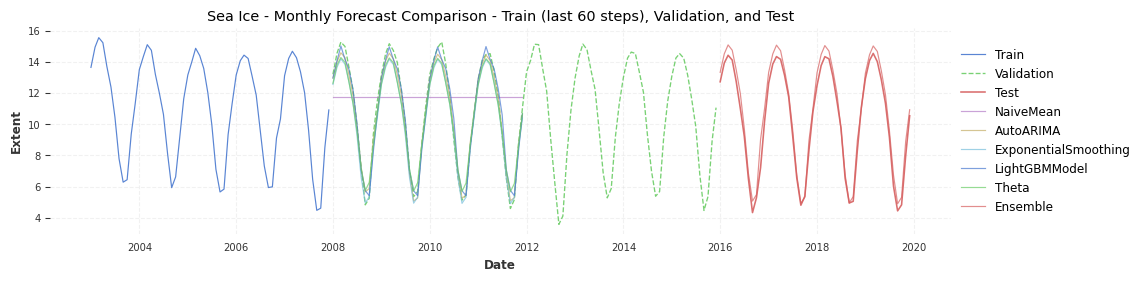

In [1]:
import warnings
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from minieda import summarize  # pip install git+https://github.com/dbolotov/minieda.git

from darts import TimeSeries
from darts.models import NaiveMean, AutoARIMA, ExponentialSmoothing, LightGBMModel, Theta
from darts.dataprocessing.transformers import Scaler
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.metrics import mae, rmse

from sklearn.linear_model import LinearRegression

# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Display and plot settings
pd.set_option("display.width", 220)
plt.rcParams.update({'font.size': 9})
plt.style.use("seaborn-v0_8-muted")
%matplotlib inline

# Functions
def split_time_series(ts, val_frac=0.1, test_frac=0.1):
    '''Split time series into train, validation, and test sets'''
    n = len(ts)
    n_test = int(n * test_frac)
    n_val = int(n * val_frac)
    n_train = n - n_val - n_test

    train, val_test = ts.split_before(n_train)
    val, test = val_test.split_before(n_val)
    return train, val, test


# Load dataset and display first few rows
df = sns.load_dataset("seaice")

print("----- SCRIPT OUTPUT -----")
print("\n----- First Few Rows of Data -----\n")
print(df.head())

# Display summary
print("\n----- Data Summary -----\n")
print(summarize(df, include_perc=False, sort=True))


# Sort by date and set Date as index
df = df.sort_values("Date").set_index("Date")

# Resample to different frequency using linear interpolation
df_resampled = df.resample("MS").interpolate("linear") # monthly

# Drop any missing values (usually at the edges)
df_resampled = df_resampled.dropna()

# Convert to Darts TimeSeries, allowing it to infer frequency
dts = TimeSeries.from_series(df_resampled["Extent"], fill_missing_dates=True, freq=None)

# Show darts info
print("\n----- darts TimeSeries Summary -----\n")
print("frequency: ", dts.freq_str)

# # Split the series into training, validation, and test sets
train, val, test = split_time_series(dts, val_frac=0.2, test_frac=0.1)

# Confirm split sizes
print(f"Train range: {train.start_time().date()} to {train.end_time().date()} ({train.n_timesteps} steps)")
print(f"Val   range: {val.start_time().date()} to {val.end_time().date()} ({val.n_timesteps} steps)")
print(f"Test  range: {test.start_time().date()} to {test.end_time().date()} ({test.n_timesteps} steps)")

# Normalize
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

# Initialize models
models = {
    "NaiveMean": NaiveMean(),
    "AutoARIMA": AutoARIMA(season_length=12, max_p=2, max_q=2,
                            max_P=1, max_Q=1, max_d=1, max_D=1),
    "ExponentialSmoothing": ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE,
                                                seasonal_periods=12,damped=True),
    "LightGBMModel": LightGBMModel(lags=12, output_chunk_length=1,
        random_state=42, verbose=-1, force_col_wise=True),
    "Theta": Theta(season_mode=SeasonalityMode.ADDITIVE),
}

# Fit base models on `train_scaled`
results = []
forecasts_val = {}   # base model forecasts on val
forecasts_test = {}  # base model forecasts on test

print("\n----- Training Models -----\n")
for name, model in models.items():
    print(f"Training {name}...")
    start = time.time()
    model.fit(train_scaled)
    train_time = time.time() - start

    # Forecast on validation set
    pred_val_scaled = model.predict(len(val_scaled))
    pred_val = scaler.inverse_transform(pred_val_scaled)
    forecasts_val[name] = pred_val

    # Forecast on test set (do not use for training ensemble)
    pred_test_scaled = model.predict(len(test_scaled))
    pred_test = scaler.inverse_transform(pred_test_scaled)
    forecasts_test[name] = pred_test

    # For reference, evaluate on validation set
    results.append({
        "Model": name,
        "MAE": mae(val, pred_val),
        "RMSE": rmse(val, pred_val),
        "Train Time (s)": train_time
    })

# Train ensemble on val set

# Collect predictions from base models
X_val = np.column_stack([f.values().flatten() for f in [
    forecasts_val["AutoARIMA"],
    forecasts_val["ExponentialSmoothing"],
    forecasts_val["Theta"],
    forecasts_val["LightGBMModel"]
]])
y_val = val.values().flatten()

ens_model = LinearRegression()
print(f"\nTraining Ensemble Model...")
start = time.time()
ens_model.fit(X_val, y_val)
train_time = time.time() - start

# Predict on test set using ensemble
X_test = np.column_stack([f.values().flatten() for f in [
    forecasts_test["AutoARIMA"],
    forecasts_test["ExponentialSmoothing"],
    forecasts_test["Theta"],
    forecasts_test["LightGBMModel"]
]])
y_test = test.values().flatten()

y_pred = ens_model.predict(X_test)
ensemble_forecast = TimeSeries.from_times_and_values(test.time_index, y_pred)

# Add ensemble to results
forecasts_test["Ensemble"] = ensemble_forecast
results.append({
    "Model": "Ensemble",
    "MAE": mae(test, ensemble_forecast),
    "RMSE": rmse(test, ensemble_forecast),
    "Train Time (s)": train_time
})

print("\n----- EVALUATION -----\n")
# Display comparison table
results_df = pd.DataFrame(results).sort_values("RMSE")
print(results_df.to_string(index=False))

# Plot forecasts for visual comparison
train_to_plot = train[-60:]  # show only the last 60 training steps

plt.figure(figsize=(12, 3))

# Plot slices of the original data
train_to_plot.plot(label="Train", linewidth=0.9, alpha=0.9)
val.plot(label="Validation", linewidth=1.0, alpha=0.9, linestyle="--")
test.plot(label="Test", linewidth=1.2, alpha=0.9)

# Plot model forecasts (all evaluated on test)
for name, forecast in forecasts_test.items():
    if forecast is not None:
        forecast.plot(label=name, linewidth=0.9, alpha=0.7)

plt.title("Sea Ice - Monthly Forecast Comparison - Train (last 60 steps), Validation, and Test")
plt.xlabel("Date")
plt.ylabel("Extent")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()